# Stacking models in Python efficiently

Source: https://www.dataquest.io/blog/introduction-to-ensembles/


Ensembles have rapidly become one of the hottest and most popular methods in applied machine learning. Virtually every winning Kaggle solution features them, and many data science pipelines have ensembles in them. Put simply, ensembles combine predictions from different models to generate a final prediction, and the more models we include the better it performs. Better still, because ensembles combine baseline predictions, they perform at least as well as the best baseline model. Ensembles give us a performance boost almost for free! 

![alt text](https://www.dataquest.io/wp-content/uploads/2019/01/network-1.png)

Example schematics of an ensemble. An input array  is fed through two preprocessing pipelines and then to a set of base learners . The ensemble combines all base learner predictions into a final prediction array . We’ll take you through the basics of ensembles — what they are and why they work so well — and provide a hands-on tutorial for building basic ensembles. By the end of this post, you will:

* understand the fundamentals of ensembles
* know how to code them
* understand the main pitfalls and drawbacks of ensembles




#Predicting Republican and Democratic donations

To illustrate how ensembles work, we’ll use a data set on U.S. political contributions. The original data set was prepared by Ben Wieder at FiveThirtyEight, who dug around the U.S. government’s political contribution registry and found that when scientists donate to politician, it’s usually to Democrats. This claim is based on the observation on the share of donations being made to Republicans and Democrats.

https://fivethirtyeight.com/features/when-scientists-donate-to-politicians-its-usually-to-democrats/

However, there’s plenty more that can be said: for instance, which scientific discipline is most likely to make a Republican donation, and which state is most likely to make Democratic donations? We will go one step further and predict whether a donation is most likely to be a to a Republican or Democrat. The data we use here is slightly adapted. We remove any donations to party affiliations other than Democrat or Republican to make our exposition a little clearer and drop some duplicate and less interesting features. 

## Libs

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pydotplus
# you can install pydotplus with: pip install pydotplus
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz







## Data

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/OzmundSedler/100-Days-Of-ML-Code/master/day_13/datasets/input.csv', header=0, sep=',')

In [0]:
df.head()

,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


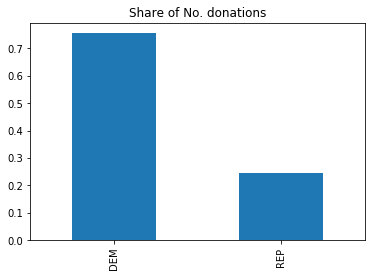

In [0]:
df.cand_pty_affiliation.value_counts(normalize=True).plot(kind="bar", title="Share of No. donations")
plt.show()

In [0]:
def get_train_test(test_size=0.95):
    """Split Data into train and test sets."""
    y = 1 * (df.cand_pty_affiliation == "REP")
    X = df.drop(["cand_pty_affiliation"], axis=1)
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    return train_test_split(X, y, test_size=test_size, random_state=42)

xtrain, xtest, ytrain, ytest = get_train_test()

The figure above is the data underlying Ben’s claim. Indeed, between Democrats and Republicans, about 75% of all contributions are made to democrats. Let’s go through the features at our disposal. We have data about the donor, the transaction, and the recipient: 

![alt text](https://www.dataquest.io/wp-content/uploads/2018/01/features.svg)

To measure how well our models perform, we use the ROC-AUC score, which trades off having high precision and high recall (if these concepts are new to you, see the Wikipedia entry on precision and recall for a quick introduction). If you haven’t used this metric before, a random guess has a score of 0.5 and perfect recall and precision yields 1.0.

#What is an ensemble?

Imagine that you are playing trivial pursuit. When you play alone, there might be some topics you are good at, and some that you know next to nothing about. If we want to maximize our trivial pursuit score, we need build a team to cover all topics. This is the basic idea of an ensemble: combining predictions from several models averages out idiosyncratic errors and yield better overall predictions. An important question is how to combine predictions. In our trivial pursuit example, it is easy to imagine that team members might make their case and majority voting decides which to pick. Machine learning is remarkably similar in classification problems: taking the most common class label prediction is equivalent to a majority voting rule. But there are many other ways to combine predictions, and more generally we can use a model to learn how to best combine predictions. 

![alt text](https://www.dataquest.io/wp-content/uploads/2019/01/ensemble_network.png)

# Understanding ensembles by combining decision trees

To illustrate the machinery of ensembles, we’ll start off with a simple interpretable model: a decision tree, which is a tree of if-then rules.he deeper the tree, the more complex the patterns it can capture, but the more prone to overfitting it will be. Because of this, we will need an alternative way of building complex models of decision trees, and an ensemble of different decision trees is one such way. We’ll use the below helper function to visualize our decision rules:

In [0]:
def print_graph(clf, feature_names):
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=False,
        out_file=None,
        feature_names=feature_names,
        class_names={0: "D", 1: "R"},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())

Let’s fit a decision tree with a single node (decision rule) on our training data and see how it perform on the test set:

Decision tree ROC-AUC score: 0.673


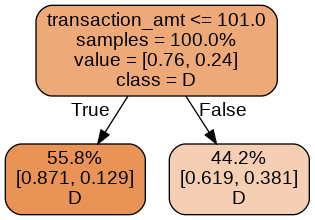

In [0]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=42)
t1.fit(xtrain, ytrain)
p = t1.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t1, xtrain.columns)

Each of the two leaves register their share of training samples, the class distribution within their share, and the class label prediction. Our decision tree bases its prediction on whether the size of the contribution is above 101.5: but it makes the same prediction regardless! This is not too surprising given that 75% of all donations are to Democrats. But it’s not making use of the data we have. Let’s use three levels of decision rules and see what we can get:

Decision tree ROC-AUC score: 0.772


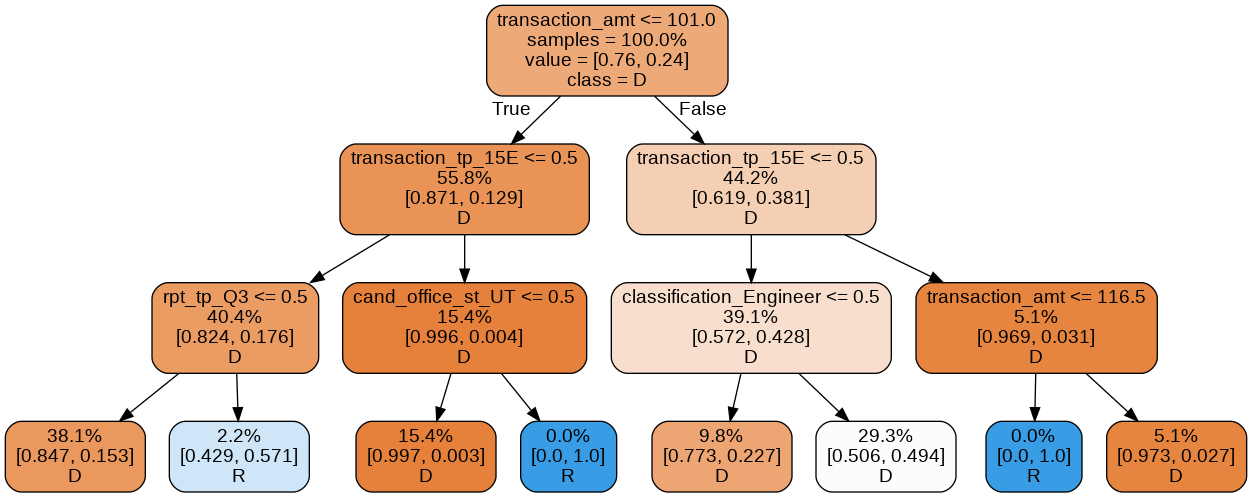

In [0]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=42)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t2, xtrain.columns)

This model is not much better than the simple decision tree: a measly 5% of all donations are predicted to go to Republicans–far short of the 25% we would expect. A closer look tells us that the decision tree uses some dubious splitting rules. A whopping 47.3% of all observations end up in the left-most leaf, while another 35.9% end up in the leaf second to the right. The vast majority of leaves are therefore irrelevant. Making the model deeper just causes it to overfit. Fixing depth, a decision tree can be made more complex by increasing “width”, that is, creating several decision trees and combining them. In other words, an ensemble of decision trees. To see why such a model would help, consider how we may force a decision tree to investigate other patterns than those in the above tree. The simplest solution is to remove features that appear early in the tree. Suppose for instance that we remove the transaction amount feature (transaction_amt), the root of the tree. Our new decision tree would look like this:

Decision tree ROC-AUC score: 0.747


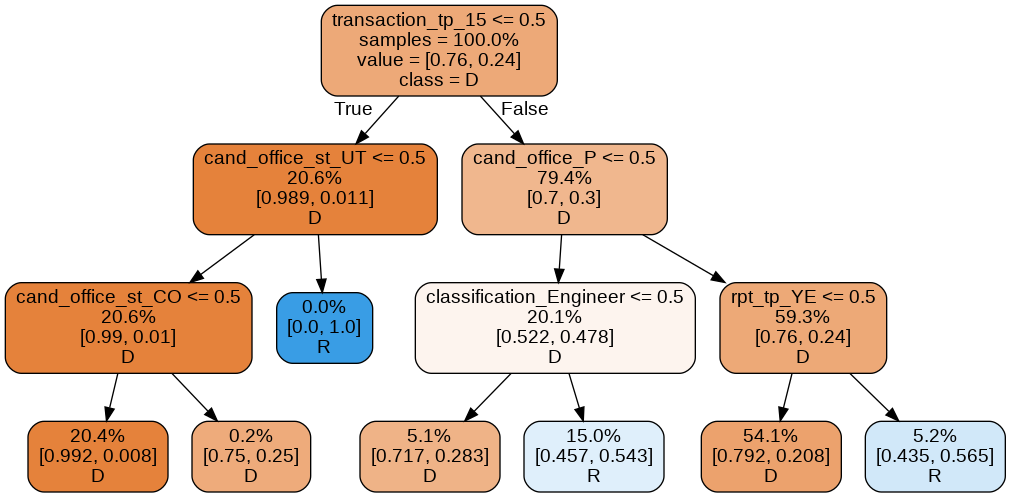

In [0]:
drop = ["transaction_amt"]
xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=42)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

The ROC-AUC score is similar, but the share of Republican donation increased to 20%. Still too low, but higher than before. Importantly, in contrast to the first tree, where most of the rules related to the transaction itself, this tree is more focused on the residency of the candidate. We now have two models that by themselves have similar predictive power, but operate on different rules. Because of this, they are likely to make different prediction errors, which we can average out with an ensemble.

# Interlude: why averaging predictions work

Why would we expect averaging predictions to work? Consider a toy example with two observations that we want to generate predictions for. The true label for the first observation is Republican, and the true label for the second observation is Democrat. In this toy example, suppose model 1 is prone to predicting Democrat while model 2 is prone to predicting Republican, as in the below table:

![alt text](https://i.imgur.com/WQVDZey.png)

If we use the standard 50% cutoff rule for making a class prediction, each decision tree gets one observation right and one wrong. We create an ensemble by averaging the model’s class probabilities, which is a majority vote weighted by the strength (probability) of model’s prediction. In our toy example, model 2 is certain of its prediction for observation 1, while model 1 is relatively uncertain. Weighting their predictions, the ensemble favors model 2 and correctly predicts Republican. For the second observation, tables are turned and the ensemble correctly predicts Democrat:

![alt text](https://i.imgur.com/72S9UEE.png)


With more than two decision trees, the ensemble predicts in accordance with the majority. For that reason, an ensemble that averages classifier predictions is known as a majority voting classifier. When an ensembles averages based on probabilities (as above), we refer to it as soft voting, averaging final class label predictions is known as hard voting. Of course, ensembles are no silver bullet. You might have noticed in our toy example that for averaging to work, prediction errors must be uncorrelated. If both models made incorrect predictions, the ensemble would not be able to make any corrections. Moreover, in the soft voting scheme, if one model makes an incorrect prediction with a high probability value, the ensemble would be overwhelmed. Generally, ensembles don’t get every observation right, but the expectation is will do better than the underlying models.



# A forest is an ensemble of trees

Returning to our prediction problem, let’s see if we can build an ensemble out of our two decision trees. We first check error correlation: highly correlated errors makes for poor ensembles.

In [0]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]

pd.DataFrame({"full_data": p1,
              "red_data": p2}).corr()

,full_data,red_data
full_data,1.000000,0.644343
red_data,0.644343,1.000000


There is some correlation, but not overly so: there’s still a good deal of prediction variance to exploit. To build our first ensemble, we simply average the two model’s predictions.

In [0]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.809


Indeed, the ensemble procedure leads to an increased score. But maybe if we had more diverse trees, we could get an even greater gain. How should we choose which features to exclude when designing the decision trees? A fast approach that works well in practice is to randomly select a subset of features, fit one decision tree on each draw and average their predictions. This process is known as bootstrapped averaging (often abbreviated bagging), and when applied to decision trees, the resultant model is a Random Forest. Let’s see what a random forest can do for us. We use the Scikit-learn implementation and build an ensemble of 10 decision trees, each fitted on a subset of 3 features.

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=42)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.847


The Random Forest yields a significant improvement upon our previous models. We’re on to something! But there is only so much you can do with decision trees. It’s time we expand our horizon.



# Ensembles as averaged predictions
Our foray into ensembles so far has shown us two important aspects of ensembles:



1.  The less correlation in prediction errors, the better
2.  The more models, the better



For this reason, it’s a good idea to use as different models as possible (as long as they perform decently). So far, we have relied on simple averaging, but later we will see to how use more complex combinations. There’s no limitation on what models to include: decision trees, linear models, kernel-based models, non-parametric models, neural networks or even other ensembles! Keep in mind though that the more models we include, the slower the ensemble becomes. To build an ensemble of various models, we begin by benchmarking a set of Scikit-learn classifiers on the dataset. To avoid repeating code, we use the below helper functions:

In [0]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

SEED = 42

def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

We’re now ready to create a prediction matrix *P* , where each feature corresponds to the predictions made by a given model, and score each model against the test set:

In [0]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models.
svm... 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


done
Done.

Scoring models.
svm                       : 0.839
knn                       : 0.781
naive bayes               : 0.805
mlp-nn                    : 0.868
random forest             : 0.847
gbm                       : 0.878
logistic                  : 0.854
Done.



That’s our baseline. The Gradient Boosting Machine (GBM) does best, followed by a simple logistic regression. For our ensemble strategy to work, prediction errors must be relatively uncorrelated. Checking that this holds is our first order of business:



     |████████████████████████████████| 235kB 2.8MB/s 


[MLENS] backend: threading


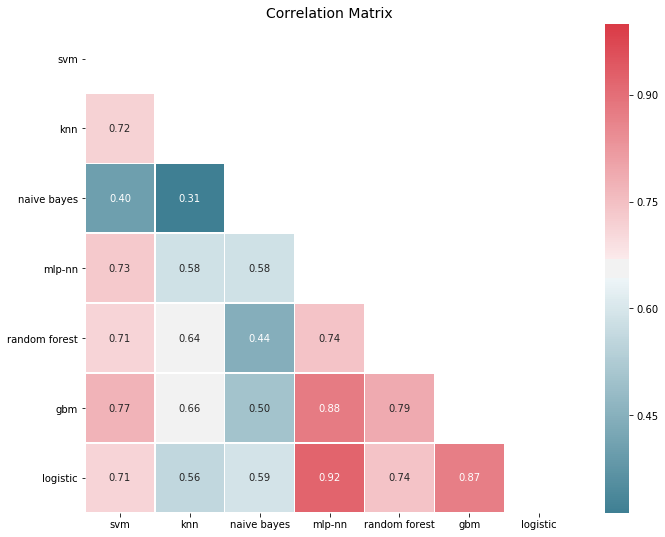

In [0]:
# You need ML-Ensemble for this figure: you can install it with: pip install mlens
!pip install mlens
from mlens.visualization import corrmat

corrmat(P.corr(), inflate=False)
plt.show()

Errors are significantly correlated, which is to be expected for models that perform well, since it’s typically the outliers that are hard to get right. Yet most correlations are in the 50-80% span, so there is decent room for improvement. In fact, if we look at error correlations on a class prediction basis things look a bit more promising:

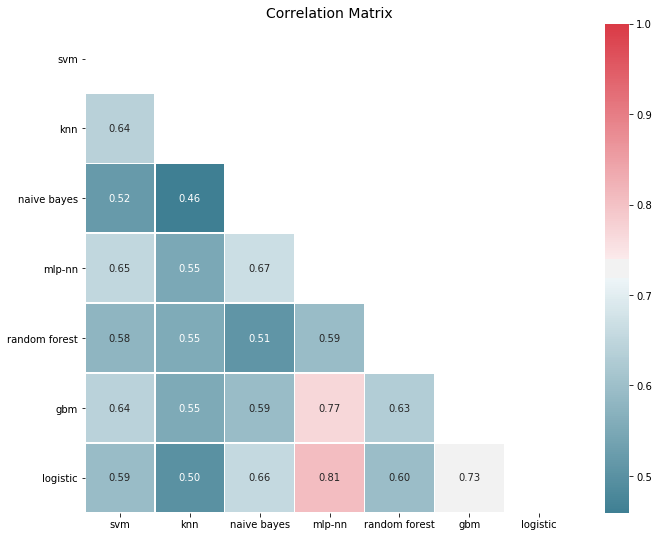

In [0]:
corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - ytest.values).corr(), inflate=False)
plt.show()

To create an ensemble, we proceed as before and average predictions, and as we might expect the ensemble outperforms the baseline. Averaging is a simple process, and if we store model predictions, we can start with a simple ensemble and increase its size on the fly as we train new models.



In [0]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.885


#Visualizing how ensembles work

We’ve understood the power of ensembles as an error correction mechanism. This means that ensembles smooth out decision boundaries by averaging out irregularities. A decision boundary shows us how an estimator carves up feature space into neighborhood within which all observations are predicted to have the same class label. By averaging out base learner decision boundaries, the ensemble is endowed with a smoother boundary that generalize more naturally. The figure below shows this in action. Here, the example is the iris data set, where the estimators try to classify three types of flowers. The base learners all have some undesirable properties in their boundaries, but the ensemble has a relatively smooth decision boundary that aligns with observations. Amazingly, ensembles both increase model complexity and acts as a regularizer!

![alt text](https://www.dataquest.io/wp-content/uploads/2019/01/ensemble_decision_regions_2d.jpg)

Another way to understand what is going on in an ensemble when the task is classification, is to inspect the Receiver Operator Curve (ROC). This curve shows us how an estimator trades off precision and recall. Typically, different base learners make different trade offs: some have higher precision by sacrificing recall, and other have higher recall by sacrificing precision. A non-linear meta learner, on the other hand, is able to, for each training point, adjust which models it relies on. This means that it can significantly reduce necessary sacrifices and retain high precision while increasing recall (or vice versa). In the figure below, the ensemble is making a much smaller sacrifice in precision to increase recall (the ROC is further in the “northeast” corner).

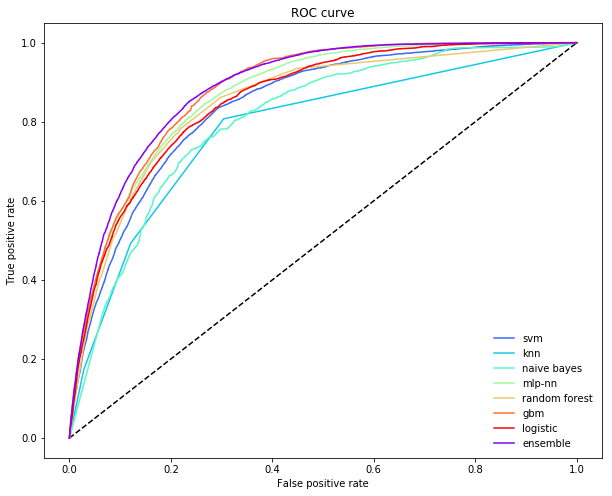

In [0]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')

    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]

    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")

#Beyond ensembles as a simple average

But wouldn’t you expect more of a boost given the variation in prediction errors? Well, one thing is a bit nagging. Some of the models perform considerably worse than others, yet their influence is just large as better performing models. This can be quite devastating with unbalanced data sets: recall that with soft voting, if a model makes an extreme prediction (i.e close to 0 or 1), that prediction has a strong pull on the prediction average. An important factor for us is whether models are able to capture the full share of Republican denotations. A simple check shows that all models underrepresent Republican donations, but some are considerably worse than others.



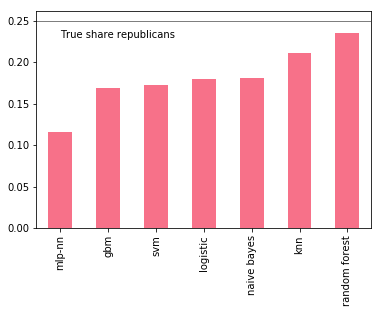

In [0]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))
p.index = ["DEM", "REP"]
p.loc["REP", :].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
plt.text(0., 0.23, "True share republicans")
plt.show()

We can try to improve the ensemble by removing the worst offender, say the Multi-Layer Perceptron (MLP):

In [0]:
include = [c for c in P.columns if c not in ["mlp-nn"]]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.883


Not really an improvement: we need a smarter way of prioritizing between models. Clearly, removing models from an ensemble is rather drastic as there may be instances where the removed model carried important information. What we really want is to learn a sensible set of weights to use when averaging predictions. This turns the ensemble into a parametric model that needs to be trained.

# Learning to combine predictions

All theory on the source link - i'm to lazy to copy formulas.

# Step 1: define a library of base learners
These are the models that take the raw input data and generates predictions, and can be anything from linear regression to a neural network to another ensemble. As always, there’s strength in diversity! The only thing to consider is that the more models we add, the slower the ensemble will be. Here, we’ll use our set of models from before:

In [0]:
base_learners = get_models()

# Step 2: define a meta learner
Which meta learner to use is not obvious, but popular choices are linear models, kernel-based models (SVMs and KNNS) and decision tree based models. But you could also use another ensemble as “meta learner”: in this special case, you end up with a two-layer ensemble, akin to a feed-forward neural network. Here, we’ll use a Gradient Boosting Machine. To ensure the GBM explores local patterns, we are restricting each of the 1000 decision trees to train on a random subset of 4 base learners and 50% of input data. This way, the GBM will be exposed to each base learner’s strength in different neighborhoods of the input space.

In [0]:
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005,
    random_state=SEED)

# Step 3: define a procedure for generating train and test sets
To keep things simple, we split the full training set into a training and prediction set of the base learners. This method is sometimes referred to as Blending. Unfortunately, the terminology differs between communities, so it’s not always easy to know what type of cross-validation the ensemble is using.

In [0]:
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
    xtrain, ytrain, test_size=0.5, random_state=SEED)

(2500,)

# Step 4: train the base learners on a training set
To train the library of base learners on the base-learner training data, we proceed as usual:

In [0]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """
    Train all base learners in the library.
    """
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

In [0]:
train_base_learners(base_learners, xtrain_base.fillna(0), ytrain_base.fillna(0))

Fitting models.
svm... 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Step 5: generate base learner predictions

In [0]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """
    Generate a prediction matrix.
    """
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p[:, 1]
        if verbose: print("done")

    return P

In [0]:
P_base = predict_base_learners(base_learners, xpred_base.fillna(0))

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


# 6. Train the meta learner


In [0]:
meta_learner.fit(P_base, ypred_base)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.005, loss='exponential', max_depth=3,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """
    Generate predictions from the ensemble.
    """
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]


In [0]:
P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done

Ensemble ROC-AUC score: 0.880


As expected, the ensemble beats the best estimator from our previous benchmark, but it doesn’t beat the simple average ensemble. That’s because we trained the base learners and the meta learner on only half the data, so a lot of information is lost. To prevent this, we need to use a cross-validation strategy.

# Training with cross-validation

During cross-validated training of the base learners, a copy of each base learner is fitted on *K* folds, and predict the left-out fold. This process is iterated until every fold has been predicted. The more folds we specify, the less data is being left out in each training pass. This makes cross-validated predictions less noisy and a better reflection of performance during test time. The cost is significantly increased training time. Fitting an ensemble with cross-validation is often referred to as stacking, while the ensemble itself is known as the Super Learner. To understand how cross-validation works, we can think of it as an outer loop over our previous ensemble. The outer loop iterates over  *K-1*  distinct test folds, with the remaining data used for training. The inner loop trains the base learners and generate predictions for the held-out data. Here’s a simple stacking implementation:

In [0]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    print("CV-predictions done")

    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)

    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner

Let’s go over the steps involved here. First, we fit our final base learners on all data: in contrast with our previous blend ensemble, base learners used at test time are trained on all available data. We then loop over all folds, then loop over all base learners to generate cross-validated predictions. These predictions are stacked to build the training set for the meta learner, which too sees all data. The basic difference between blending and stacking is therefore that stacking allows both base learners and the meta learner to train on the full data set. Using 2-fold cross-validation, we can measure the difference this makes in our case:

In [0]:
from sklearn.model_selection import KFold

# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), xtrain.values, ytrain.values, KFold(2))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Fitting final base learners...

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


done
Generating cross-validated predictions...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 done


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 done
CV-predictions done
Fitting meta learner...done

Ensemble ROC-AUC score: 0.887


Stacking yields a sizeable increase in performance: in fact, it gives us our best score so far. This outcome is typical for small and medium-sized data sets, where the effect of blending can be severe. As the data set size increases, blending and stacking performs similarly. Stacking comes with its own set of shortcomings, particularly speed. In general, we need to be aware of there important issues when it comes to implementing ensembles with cross-validation:

1. Computational complexity
2. Structural complexity (risk of information leakage)
3. Memory consumption

It’s important to understand these in order to work with ensembles efficiently, so let’s go through each in turn.



# 1. Computational complexity

Suppose we want to use 10 folds for stacking. This would require training all base learners 10 times on 90% of the data, and once on all data. With 4 base learners, the ensemble would roughly be 40 times slower than using the best base learner. But each cv-fit is independent, so we don’t need to fit models sequentially. If we could fit all folds in parallel, the ensemble would only be roughly 4 times slower than the best base learner, a dramatic improvement. Ensembles are prime candidates for parallelization, and it is critical to leverage this capability to the greatest extent possible. Fitting all folds for all models in parallel, the time penalty for the ensemble would be negligible. To hone this point in, below is a benchmark from ML-Ensemble that shows the time it takes to fit an ensemble via stacking or blending either sequentially or in parallel on 4 threads.

![alt text](https://www.dataquest.io/wp-content/uploads/2019/01/scale_cpu-1.png)


# 2. Structural complexity

Once we decide to use the entire training set to meta learner, we must worry about information leakage. This phenomena arises when we mistakenly predict samples that were used during training, for instance by mixing up our folds or using a model trained on the wrong subset. When there’s information leakage in the training set of the meta learner, it will not learn to properly correct for base learner predictions errors: garbage in, garbage out. Spotting such bugs though is extremely difficult.


# 3. Memory consumption

The final issue arises with parallelization, especially by multi-processing as is often the case in Python. In this case, each sub-process has its own memory and therefore needs to copy all data from the parent process. A naive implementation will therefore copy all data to all processes, eating up memory and wasting time on data serialization. Preventing this requires sharing data memory, which in turns easily cause data corruption.

# Upshot: use packages

The upshot is that you should use a unit-tested package and focus on building your machine learning pipeline. In fact, once you’ve settled on an ensemble package, building ensembles become really easy: all you need to do is specify the base learners, the meta learner, and a method for training the ensemble. Fortuntately, there are many packages available in all popular programming languages, though they come in different flavors. At the end of this post, we list some as reference. For now, let’s pick one and see how a stacked ensemble does on our political contributions data set. Here, we use ML-Ensemble and build our previous generalized ensemble, but now using 10-fold cross-validation:

In [0]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=42,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True)
sl.add_meta(meta_learner, proba=True)

SuperLearner(array_check=None, backend=None, folds=10,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=10, raise_on_e...er=None)],
   n_jobs=-1, name='group-11', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20, scorer=None, shuffle=False,
       verbose=2)

In [0]:
# Train the ensemble
sl.fit(xtrain, ytrain)

# Predict the test set
p_sl = sl.predict_proba(xtest)

print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(ytest, p_sl[:, 1]))

In [0]:
plot_roc_curve(ytest, p.reshape(-1, 1), P.mean(axis=1), ["Simple average"], "Super Learner")

I got another error due to data hasnt been preprocessed, so i just leave the last graph from article as image:

![alt text](https://www.dataquest.io/wp-content/uploads/2019/01/output_59_0.png)